In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

import divebomb

import time
import pickle

import importlib

np.random.seed(0)

import Preprocessor
import Parameters
import HHMM
import Visualisor

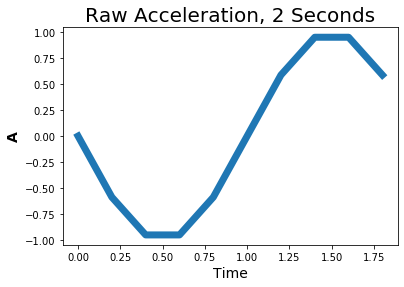

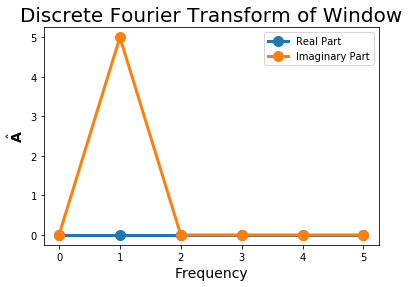

In [12]:
X = np.linspace(0,2,11)[:-1]
Y = -np.sin(np.pi*X) #+ 3*np.cos(2*X)
plt.plot(X,Y,linewidth=7.0)
plt.xlabel('Time',fontsize=14)
plt.ylabel('$\mathbf{A}$',fontsize=14)
plt.title('Raw Acceleration, 2 Seconds',fontsize=20)
plt.show()
fft = np.fft.rfft(Y)
plt.plot(np.real(fft),'.-',markersize=20,linewidth=3.0)
plt.plot(np.imag(fft),'.-',markersize=20,linewidth=3.0)
plt.title('Discrete Fourier Transform of Window',fontsize=20)
plt.xlabel('Frequency',fontsize=14)
plt.ylabel('$\hat{\mathbf{A}}$',fontsize=14)
plt.legend(['Real Part','Imaginary Part'])

In [13]:
print(len(np.fft.rfft(Y)))
print(np.fft.fft(Y))

6
[ 2.10602227e-16+0.00000000e+00j  2.33486982e-16+5.00000000e+00j
 -1.43668053e-16-1.45919696e-16j -9.78687937e-17+0.00000000e+00j
 -2.67794761e-16-2.36103028e-16j  3.67949427e-16-2.22044605e-16j
 -2.67794761e-16+2.36103028e-16j -5.44045103e-17-2.22044605e-16j
 -1.43668053e-16+1.45919696e-16j  1.63160295e-16-5.00000000e+00j]


In [2]:
pars = Parameters.Parameters()

pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'FoVeDBA_low':{'thresh':5,'corr':True,'f':'gamma'}}]

prep = Preprocessor.Preprocessor(pars)


df = prep.load_data(pars.cvc_file,
                    pars.csv_file,
                    pars.cvc_cols)

df = prep.prune_cols(df)

df = prep.prune_times(df,
                      pars.stime,
                      pars.etime,
                      pars.drop_times)

df = prep.fix_pressure(df)

df = prep.find_Vz(df)

df = prep.smooth_columns(df,
                         pars.smoother,
                         pars.smooth_cols)

df,dive_df = prep.find_dives(df)

data = prep.get_all_features(df,dive_df)

viz = Visualisor.Visualisor(pars,data,df)

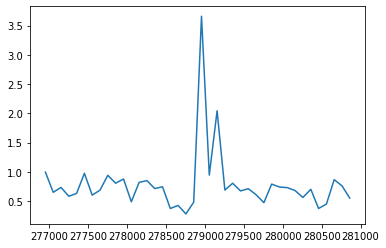

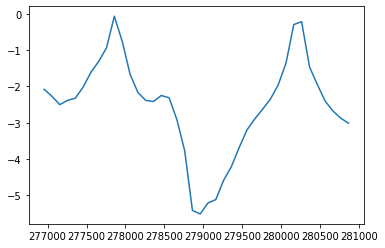

TypeError: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='.')` instead of `Series.plot('.',)`.

In [71]:
df.iloc[266000:270000:100]['VeDBA'].plot()
plt.show()
df.iloc[266000:270000:100]['elevation'].plot()
plt.show()
df.iloc[266000:270000:100]['Vz'].plot('.')
plt.show()

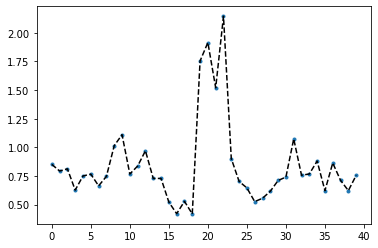

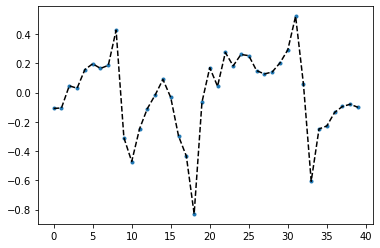

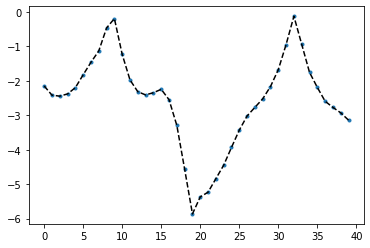

In [77]:
start = 266000
end = 270000
jump = 100

x = []
VeDBA = []
Vz = []
elevation = []


for i in range(start,end,jump):
    x.append(i)
    VeDBA.append(np.mean(df.iloc[i:i+jump]['VeDBA']))
    Vz.append(np.mean(df.iloc[i:i+jump]['Vz']))
    elevation.append(np.mean(df.iloc[i:i+jump]['elevation']))
plt.plot(VeDBA,'.')
plt.plot(VeDBA,'k--')
plt.show()
plt.plot(Vz,'.')
plt.plot(Vz,'k--')
plt.show()
plt.plot(elevation,'.')
plt.plot(elevation,'k--')
plt.show()

In [46]:
df

,depth,VeDBA,time,sec_from_start,hr_from_start,time_series,elevation,Vz,dive_num
2974,0.508553,1.032325,2019-09-02 13:20:59.480,2290.48,0.636244,0,-0.508553,-0.980659,0
2975,0.533410,1.188776,2019-09-02 13:20:59.500,2290.50,0.636250,0,-0.533410,-0.972403,0
2976,0.558267,1.093266,2019-09-02 13:20:59.520,2290.52,0.636256,0,-0.558267,-0.959830,0
2977,0.564452,1.105400,2019-09-02 13:20:59.540,2290.54,0.636261,0,-0.564452,-0.945602,0
2978,0.576861,1.000821,2019-09-02 13:20:59.560,2290.56,0.636267,0,-0.576861,-0.927431,0
...,...,...,...,...,...,...,...,...,...
578801,0.429446,0.384999,2019-09-02 17:59:58.380,19029.38,5.285939,2,-0.429446,-0.715344,266
578802,0.466789,0.406580,2019-09-02 17:59:58.400,19029.40,5.285944,2,-0.466789,-0.708810,266
578803,0.473013,0.418033,2019-09-02 17:59:58.420,19029.42,5.285950,2,-0.473013,-0.702803,266
578804,0.485461,0.456635,2019-09-02 17:59:58.440,19029.44,5.285956,2,-0.485461,-0.696690,266
